In [95]:
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
# torch._C._cuda_init()

In [96]:
%matplotlib
%pylab inline

from pyc3 import typesys, timeseries, tsutils as tsu

import pandas as pd
from datetime import datetime

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
# R2 = 1 - (y-f(x))^2 / (y-mean(y))^2
from sklearn.metrics import r2_score

plt.rcParams['figure.figsize'] = (15,8)

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [97]:
# add helper functions
from sklearn import metrics
def split_train_test(ts, pct):
    df = tsu.to_DataFrame(ts)
    df = df[df['HasEverFailed']<1]
    df = df.drop(['HasEverFailed'],axis=1)
    df['new_index'] = ["{}_{}".format(s, d) for s,d in zip(df.source, df.index)]
    uniques=list(df.source.unique())
    chosen = list(random.choice(uniques,int(round(pct*len(uniques))),replace=False))
    df_train = df[df['source'].isin(chosen)].set_index('new_index').drop('source', axis=1)
    df_test = df[~df['source'].isin(chosen)].set_index('new_index').drop('source', axis=1)
    
    return df_train, df_test

def split_train_test_date(ts, date_split):
    df = tsu.to_DataFrame(ts)
    df['new_index'] = ["{}_{}".format(s, d) for s,d in zip(df.source, df.index)]

    df_train = df[df.index <= date_split].set_index('new_index').drop('source', axis=1)
    df_test = df[df.index > date_split].set_index('new_index').drop('source', axis=1)
    
    return df_train, df_test

def plot_roc(predictions, actuals, label=""): 
    fpr, tpr, thresholds = metrics.roc_curve(actuals, predictions)
    auc = metrics.roc_auc_score(actuals, predictions)
    plt.plot(fpr, tpr, label="auc:{:.3f} {}".format(auc, label))
    plt.title('ROC Curve')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend(loc=4)


In [98]:
c3 = typesys.C3ServerConnection("https://lightbulb-demo.c3-e.com", "lightbulb","demo")
# mehdi.maasoumy@c3energy.com

User: rasoul.ghadami@sunpowercorp.com
Password: ········
Valid username and password


In [99]:
c3.importAll()

Tag.getModules took  1009.5789 ms
Imported 2413 types from lightbulb/demo in  10454.731 ms


# Define a metric for prediction label 

In [100]:
# Define custom metric on the fly to use as the target label for supervised learning
failure_metric = c3.CompoundMetric(id="FailureWindow",
                                   name="FailureWindow", 
                                   expression="window('MAX', IsDefective, 0, 30) > 0")

# Export data from C3 Platform

In [101]:
start=datetime(2011,1,1)
end=datetime(2016,1,1)
interval='DAY'

expressions = ['SwitchCountPreviousWeek','DurationOnInHours','StandardDeviationWattsPreviousWeek',
               "HasEverFailed","FailureWindow"]

spec = c3.EvalMetricsSpec(expressions=expressions,
                          filter="startsWith(id, 'SMBLB')", 
                          interval=interval,
                          start=start,
                          end=end, limit=100)

em = c3.SmartBulb.evalMetricsWithMetadata(spec, [failure_metric])  

SmartBulb.evalMetricsWithMetadata took 34566.5660 ms


In [102]:
emr = tsu.to_timeseries(em)

In [103]:
ts = emr.get("SMBLB2", {}).get('data')
ts

Time,SwitchCountPreviousWeek,HasEverFailed,FailureWindow,StandardDeviationWattsPreviousWeek,DurationOnInHours
2011-01-01 00:00:00,0.0,0.0,0.0,0.0,4.0
2011-01-02 00:00:00,4.0,0.0,0.0,0.0,13.0
2011-01-03 00:00:00,12.0,0.0,0.0,1.92686597873,22.0
2011-01-04 00:00:00,18.0,0.0,0.0,1.57327948354,30.0
2011-01-05 00:00:00,26.0,0.0,0.0,1.29481471218,42.0
2011-01-06 00:00:00,30.0,0.0,0.0,1.67604237881,50.0
2011-01-07 00:00:00,38.0,0.0,0.0,1.51415007941,53.0
2011-01-08 00:00:00,42.0,0.0,0.0,1.89627872842,55.0
2011-01-09 00:00:00,40.0,0.0,0.0,2.21966618874,63.0
2011-01-10 00:00:00,40.0,0.0,0.0,2.17998046203,70.0


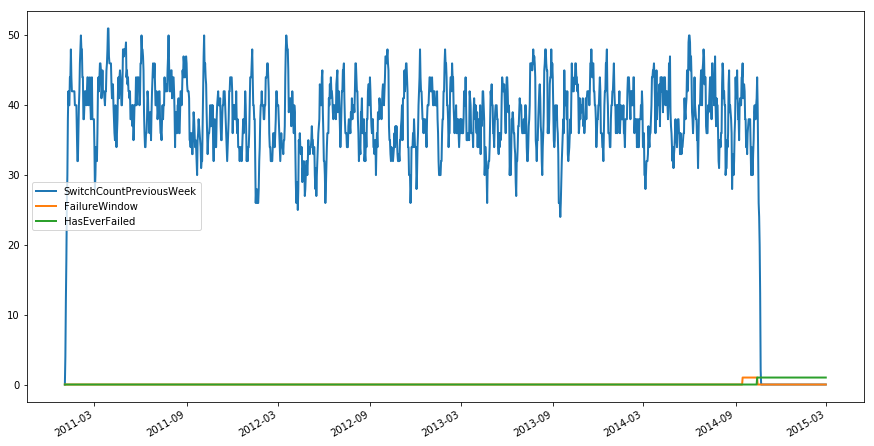

In [108]:
tsu.plot(ts[["SwitchCountPreviousWeek","FailureWindow","HasEverFailed"], "2010-01-01":"2015-03-01"])

# Split dataset into Train and Test

In [109]:
df_train, df_test = split_train_test(emr, 0.8)

In [110]:
print 'train set size: ', df_train.shape
print 'test set size: ', df_test.shape
# df_train.head()

train set size:  (112752, 4)
test set size:  (27882, 4)


In [111]:
feature_names = ['SwitchCountPreviousWeek','StandardDeviationWattsPreviousWeek','DurationOnInHours']
label = ['FailureWindow']


def dataLoader(dataset, scaler, batch_size=100, shuffle_flag=True,
              feature_names=feature_names, label=label):
    """
    Argument:
    dataset -- input dataset of type pandas.DataFrame of shape (m * input_size) where 
                    m is the number of data point in the dataset and
                    input_size is the number of features 
                    
    batch_size -- integer
    shuffle -- whether or not to shuffle the dataset
    
    Returns:
    batches -- python list containing m//batch_size bacth datasets of type numpy.ndarray 
                    each of size (batch_size * input_size)
    """
    m = dataset.shape[0]
    np.random.seed(1)
    if shuffle_flag:
        dataset = shuffle(dataset)
    
    X = dataset[feature_names].values
    X = scaler.transform(X)
    
    y = dataset[label].values
    
    
    X_batches = [X[i*batch_size:(i+1)*batch_size, :] for i in range(m//batch_size)]
    y_batches = [y[i*batch_size:(i+1)*batch_size, :].astype(int) for i in range(m//batch_size)]

    if m%batch_size!=0:
        X_batches.append(X[(m//batch_size)*batch_size:, :])
        y_batches.append(y[(m//batch_size)*batch_size:, :].astype(int))
        
    return zip(X_batches, y_batches)

In [112]:
scaler = StandardScaler()
scaler.fit(df_train[feature_names])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [113]:
def evaluate_model(data_loader_input, nn_model):
    correct = 0
    total = 0
    predicted_list = []
    labels_list = []
    prob_predicted_list = []
    
    for X, y in data_loader_input:
        X = Variable(torch.Tensor(X), requires_grad=True) 
        y = torch.LongTensor(y.flatten())
        outputs = net(X)
        _, predicted = torch.max(outputs.data, 1)
        prob_predicted = outputs.data[:,1]
        total += y.size(0)
        correct += (predicted == y).sum()
        
        labels_list.extend(y.numpy())
        predicted_list.extend(predicted.numpy())
        prob_predicted_list.extend(prob_predicted)
        
    return 100. * correct / total, predicted_list, prob_predicted_list, labels_list


In [46]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable

# Hyper Parameters 
input_size = 3 
hidden_size = 6 
hidden_size2 = 4
num_classes = 2 
num_epochs = 200
batch_size = 3000 
learning_rate =  0.001 # 0.005
loss_list = []

# Data Loader (Input Pipeline)
train_loader = dataLoader(dataset=df_train, scaler=scaler, batch_size=batch_size, shuffle_flag=True, feature_names=feature_names, label=label)
test_loader = dataLoader(dataset=df_test, scaler=scaler, batch_size=batch_size, shuffle_flag=True, feature_names=feature_names, label=label)

# Neural Network Model (1 hidden layer)
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size2)
        self.fc4 = nn.Linear(hidden_size2, num_classes) 
#         self.m = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        return out 
    
net = Net(input_size, hidden_size, num_classes)

    
# Loss and Optimizer
criterion = nn.CrossEntropyLoss(size_average=True) 
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)  

# Train the Model
for epoch in range(num_epochs):
    for i, (X, y) in enumerate(train_loader):  
        # Convert torch tensor to Variable
        X = Variable(torch.Tensor(X), requires_grad=True)
        y = Variable(torch.LongTensor(y.flatten()))
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()  # zero the gradient buffer
        outputs = net(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        
        if (i) % 10 == 0:
            loss_list.append(loss.data[0])
            if (epoch)%50 ==0:
                accuracy, _, _, _ = evaluate_model(train_loader, net)
                print ('Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Accuracy : %.2f %%' 
                       %(epoch, num_epochs, i, len(df_train)//batch_size, loss.data[0], accuracy))


# Test the Model on Train set
train_accuracy, _, _, _ = evaluate_model(train_loader, net)
print('\nAccuracy of the network on the %d train lightbulbs: %.2f %%' % (df_train.shape[0], train_accuracy))

# Test the Model on Test set
test_accuracy, _, _, _ = evaluate_model(test_loader, net)
print('\nAccuracy of the network on the %d test lightbulbs: %.2f %%' % (df_test.shape[0], test_accuracy))

# Save the Model
torch.save(net.state_dict(), 'model.pkl')

Epoch [0/200], Step [0/37], Loss: 0.7629, Accuracy : 2.07 %
Epoch [0/200], Step [10/37], Loss: 0.7348, Accuracy : 2.07 %
Epoch [0/200], Step [20/37], Loss: 0.7087, Accuracy : 3.30 %
Epoch [0/200], Step [30/37], Loss: 0.6833, Accuracy : 97.93 %
Epoch [50/200], Step [0/37], Loss: 0.0365, Accuracy : 97.93 %
Epoch [50/200], Step [10/37], Loss: 0.0405, Accuracy : 97.93 %
Epoch [50/200], Step [20/37], Loss: 0.0372, Accuracy : 97.93 %
Epoch [50/200], Step [30/37], Loss: 0.0413, Accuracy : 97.93 %
Epoch [100/200], Step [0/37], Loss: 0.0342, Accuracy : 97.93 %
Epoch [100/200], Step [10/37], Loss: 0.0388, Accuracy : 97.93 %
Epoch [100/200], Step [20/37], Loss: 0.0362, Accuracy : 97.93 %
Epoch [100/200], Step [30/37], Loss: 0.0399, Accuracy : 97.93 %
Epoch [150/200], Step [0/37], Loss: 0.0337, Accuracy : 97.93 %
Epoch [150/200], Step [10/37], Loss: 0.0383, Accuracy : 97.93 %
Epoch [150/200], Step [20/37], Loss: 0.0359, Accuracy : 97.93 %
Epoch [150/200], Step [30/37], Loss: 0.0400, Accuracy : 97.

In [21]:
# Accuracy of the network on the 112416 train lightbulbs: 98.07 %
# Accuracy of the network on the 28218 test lightbulbs: 97.67 %

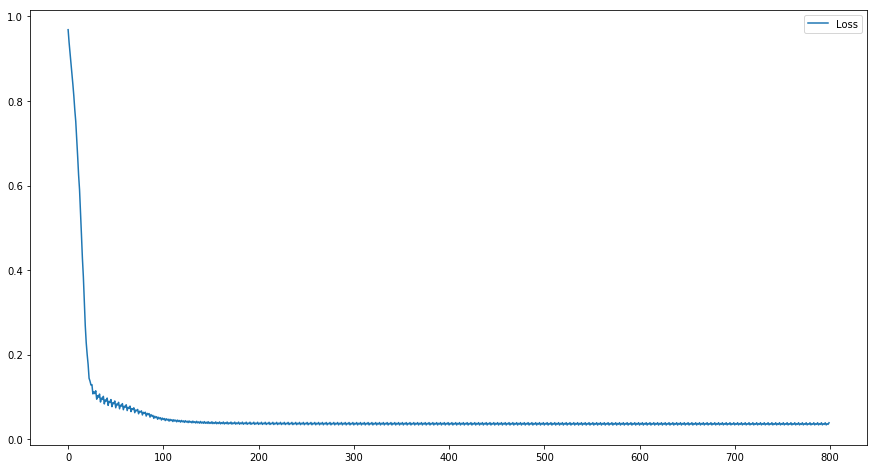

In [42]:
plt.plot(range(len(loss_list)), loss_list, label="Loss")
plt.legend()

# ROC

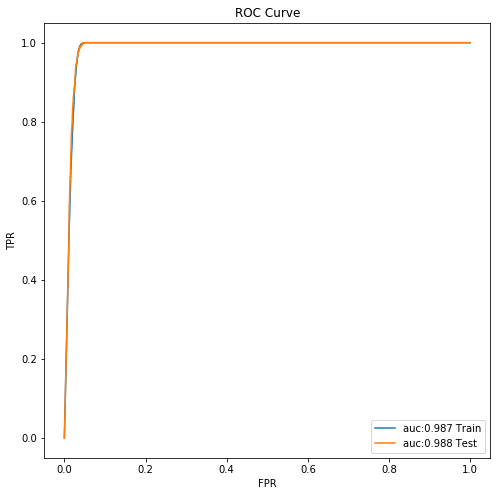

In [43]:
acc_train, predicted_list_train, prob_predicted_list_train, labels_list_train = evaluate_model(train_loader, net)
acc_test, predicted_list_test, prob_predicted_list_test, labels_list_test = evaluate_model(test_loader, net)

plt.figure(figsize=(8,8))
plot_roc(prob_predicted_list_train, labels_list_train, 'Train') 
plot_roc(prob_predicted_list_test, labels_list_test, "Test") 

In [47]:
# print "Percentage of 1's in test correctly predicted: %.2f %%"%(sum(np.array(predicted_list_test) * np.array(labels_list_test)) * 100.0 / np.sum(labels_list_test))
# print "Percentage of 1's in train correctly predicted: %.2f %%"%(sum(np.array(predicted_list_train) * np.array(labels_list_train)) * 100.0 / np.sum(labels_list_train))

In [48]:
# print df_train['FailureWindow'].sum(), df_train['FailureWindow'].sum()*100.0/df_train.shape[0]
# print df_test['FailureWindow'].sum(), df_test['FailureWindow'].sum()*100/df_test.shape[0]

## DL Model for Regression

In [4]:
c3_dev = typesys.C3ServerConnection("https://lightbulb-demo.c3-e.com", "lightbulb","nikolai")
c3_dev.importAll()
# mehdi.maasoumy@c3energy.com

User: mehdi.maasoumy@c3energy.com
Password: ········
Valid username and password
Tag.getModules took  1051.2409 ms
Imported 2344 types from lightbulb/nikolai in   9570.181 ms


In [5]:
# Define custom metric on the fly to use as the target label for supervised learning
new_metric = c3_dev.SimpleMetric(id = "TotalPower", name = "TotalPower", 
                             srcType= "Building",
                             path = "apartments.fixtures.bulbHistory.from.bulbMeasurements",
                                   expression="sum(sum(normalized.data.power))")

In [6]:
start=datetime(2011,1,1)
end=datetime(2012,1,1)
interval='HOUR'

expressions = ["Holiday","DayOfWeek","MonthOfYear","HourOfDay","TotalPower"]

spec = c3_dev.EvalMetricsSpec(expressions=expressions,
                          filter="startsWith(id, 'bld')", 
                          interval=interval,
                          start=start,
                          end=end, limit=100)

em = c3_dev.Building.evalMetricsWithMetadata(spec,[new_metric])  

Building.evalMetricsWithMetadata took 11759.5339 ms


In [7]:
emr = tsu.to_timeseries(em)

In [8]:
df_train, df_test = split_train_test_date(emr, datetime(2011,9,30))

In [9]:
feature_names = ["Holiday","DayOfWeek","MonthOfYear","HourOfDay"]
label = ['TotalPower']


def dataLoader(dataset, scaler, batch_size=100, shuffle_flag=True,
              feature_names=feature_names, label=label):
    """
    Argument:
    dataset -- input dataset of type pandas.DataFrame of shape (m * input_size) where 
                    m is the number of data point in the dataset and
                    input_size is the number of features 
                    
    batch_size -- integer
    shuffle -- whether or not to shuffle the dataset
    
    Returns:
    batches -- python list containing m//batch_size bacth datasets of type numpy.ndarray 
                    each of size (batch_size * input_size)
    """
    m = dataset.shape[0]
    np.random.seed(1)
    if shuffle_flag:
        dataset = shuffle(dataset)
    
    X = dataset[feature_names].values
    X = scaler.transform(X)
    
    y = dataset[label].values
    
    
    X_batches = [X[i*batch_size:(i+1)*batch_size, :] for i in range(m//batch_size)]
    y_batches = [y[i*batch_size:(i+1)*batch_size, :] for i in range(m//batch_size)]

    if m%batch_size!=0:
        X_batches.append(X[(m//batch_size)*batch_size:, :])
        y_batches.append(y[(m//batch_size)*batch_size:, :])
        
    return zip(X_batches, y_batches)

In [10]:
scaler = StandardScaler()
scaler.fit(df_train[feature_names])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [11]:
def evaluate_regression_model(input_train_loader, input_net):
    labels_list = []
    prob_predicted_list = []
    for X, y in input_train_loader:
        X = Variable(torch.Tensor(X), requires_grad=True) 
        y = torch.Tensor(y.flatten())
        labels_list.extend(y.numpy())
        outputs = input_net(X)
        prob_predicted = outputs.data.numpy().T[0]
        prob_predicted_list.extend(prob_predicted)
        
    r2 = r2_score(np.array(prob_predicted_list), np.array(labels_list))
    return r2, prob_predicted_list, labels_list

In [ ]:
# Data Loader (Input Pipeline)
train_loader = dataLoader(dataset=df_train, scaler=scaler, batch_size=batch_size, shuffle_flag=True, feature_names=feature_names, label=label)
test_loader = dataLoader(dataset=df_test, scaler=scaler, batch_size=batch_size, shuffle_flag=True, feature_names=feature_names, label=label)

# Neural Network Model (1 hidden layer)
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, n_output):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size2)
        self.fc4 = nn.Linear(hidden_size2, num_classes) 

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        return out 


In [91]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable

# Hyper Parameters 
input_size = 4 
hidden_size = 6 
hidden_size2 = 4
num_classes = 1 
num_epochs = 600
batch_size = 3000 
learning_rate =  0.08 # 0.005
# loss_list = []
# net = Net(input_size, hidden_size, num_classes)

# Loss and Optimizer
# criterion = nn.CrossEntropyLoss() 
criterion = nn.MSELoss(size_average=True) 
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)  

# Train the Model
for epoch in range(1, num_epochs+1):
    for i, (X, y) in enumerate(train_loader):  
        # Convert torch tensor to Variable
        X = Variable(torch.Tensor(X), requires_grad=True)
        y = Variable(torch.Tensor(y.flatten()))
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()  # zero the gradient buffer
        outputs = net(X)
        loss = criterion(outputs, y)

        loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
        # plot and show learning process
            loss_list.append(loss.data[0])
            if (epoch)%50 ==0:
                r2_train, _, _ = evaluate_regression_model(train_loader, net)
                r2_test, _, _ = evaluate_regression_model(test_loader, net)
                print ('Epoch [%d/%d], Step [%d/%d], Loss: %.4f, R^2 train: %.2f %%, R^2 test: %.2f %%' 
                         %(epoch, num_epochs, i+1, len(df_train)//batch_size, loss.data[0], r2_train*100, r2_test*100))
            

Epoch [50/600], Step [10/10], Loss: 531.2553, R^2 train: 94.44 %, R^2 test: 94.02 %
Epoch [100/600], Step [10/10], Loss: 460.7777, R^2 train: 95.07 %, R^2 test: 94.67 %
Epoch [150/600], Step [10/10], Loss: 450.2010, R^2 train: 95.24 %, R^2 test: 94.62 %
Epoch [200/600], Step [10/10], Loss: 446.2344, R^2 train: 94.76 %, R^2 test: 94.37 %
Epoch [250/600], Step [10/10], Loss: 438.0811, R^2 train: 95.42 %, R^2 test: 94.99 %
Epoch [300/600], Step [10/10], Loss: 437.1635, R^2 train: 95.60 %, R^2 test: 95.13 %
Epoch [350/600], Step [10/10], Loss: 453.7561, R^2 train: 95.52 %, R^2 test: 95.09 %
Epoch [400/600], Step [10/10], Loss: 430.5034, R^2 train: 95.48 %, R^2 test: 95.04 %
Epoch [450/600], Step [10/10], Loss: 429.2122, R^2 train: 95.58 %, R^2 test: 95.05 %
Epoch [500/600], Step [10/10], Loss: 428.3440, R^2 train: 95.55 %, R^2 test: 95.04 %
Epoch [550/600], Step [10/10], Loss: 430.3905, R^2 train: 95.61 %, R^2 test: 95.17 %
Epoch [600/600], Step [10/10], Loss: 433.4113, R^2 train: 95.71 %,

In [ ]:
# History of logs:
# Epoch [50/300], Step [10/10], Loss: 10800.9111, R^2 train: -3391.81 %, R^2 test: -4895.66 %
# Epoch [100/300], Step [10/10], Loss: 7200.9326, R^2 train: -452.44 %, R^2 test: -1161.15 %
# Epoch [150/300], Step [10/10], Loss: 4837.6431, R^2 train: -28.62 %, R^2 test: -69.20 %
# Epoch [200/300], Step [10/10], Loss: 3979.1484, R^2 train: 33.05 %, R^2 test: 26.79 %
# Epoch [250/300], Step [10/10], Loss: 3663.1011, R^2 train: 48.93 %, R^2 test: 46.97 %
# Epoch [300/300], Step [10/10], Loss: 3572.4573, R^2 train: 54.25 %, R^2 test: 53.41 %
# Epoch [50/300], Step [10/10], Loss: 3501.3167, R^2 train: 56.68 %, R^2 test: 55.89 %
# Epoch [100/300], Step [10/10], Loss: 3425.3396, R^2 train: 58.05 %, R^2 test: 57.25 %
# Epoch [150/300], Step [10/10], Loss: 3357.1313, R^2 train: 59.26 %, R^2 test: 58.39 %
# Epoch [200/300], Step [10/10], Loss: 3303.1904, R^2 train: 60.18 %, R^2 test: 59.27 %
# Epoch [250/300], Step [10/10], Loss: 3251.2109, R^2 train: 61.05 %, R^2 test: 60.07 %
# Epoch [300/300], Step [10/10], Loss: 3208.8000, R^2 train: 61.76 %, R^2 test: 60.69 %
# Epoch [50/300], Step [10/10], Loss: 3182.4956, R^2 train: 62.70 %, R^2 test: 61.49 %
# Epoch [100/300], Step [10/10], Loss: 3177.7046, R^2 train: 62.87 %, R^2 test: 61.70 %
# Epoch [150/300], Step [10/10], Loss: 3176.4360, R^2 train: 62.92 %, R^2 test: 61.84 %
# Epoch [200/300], Step [10/10], Loss: 3175.9106, R^2 train: 62.93 %, R^2 test: 61.87 %
# Epoch [250/300], Step [10/10], Loss: 3175.5605, R^2 train: 62.94 %, R^2 test: 61.90 %
# Epoch [300/300], Step [10/10], Loss: 3175.7004, R^2 train: 62.93 %, R^2 test: 61.89 %
# Epoch [50/300], Step [10/10], Loss: 3180.2178, R^2 train: 63.22 %, R^2 test: 62.10 %
# Epoch [100/300], Step [10/10], Loss: 3180.1514, R^2 train: 63.21 %, R^2 test: 62.09 %
# Epoch [150/300], Step [10/10], Loss: 3180.1458, R^2 train: 63.22 %, R^2 test: 62.11 %
# Epoch [200/300], Step [10/10], Loss: 3179.7847, R^2 train: 63.22 %, R^2 test: 62.12 %
# Epoch [250/300], Step [10/10], Loss: 3179.7534, R^2 train: 63.22 %, R^2 test: 62.12 %
# Epoch [300/300], Step [10/10], Loss: 3179.6980, R^2 train: 63.22 %, R^2 test: 62.12 %
# Epoch [50/300], Step [10/10], Loss: 3181.4817, R^2 train: 63.26 %, R^2 test: 62.14 %
# Epoch [100/300], Step [10/10], Loss: 3181.2173, R^2 train: 63.27 %, R^2 test: 62.16 %
# Epoch [150/300], Step [10/10], Loss: 3181.2634, R^2 train: 63.26 %, R^2 test: 62.14 %
# Epoch [200/300], Step [10/10], Loss: 3181.2109, R^2 train: 63.26 %, R^2 test: 62.15 %
# Epoch [250/300], Step [10/10], Loss: 3181.2266, R^2 train: 63.27 %, R^2 test: 62.17 %
# Epoch [300/300], Step [10/10], Loss: 3181.1670, R^2 train: 63.27 %, R^2 test: 62.17 %
# Epoch [50/600], Step [10/10], Loss: 3176.8140, R^2 train: 61.42 %, R^2 test: 60.98 %
# Epoch [100/600], Step [10/10], Loss: 3177.4946, R^2 train: 61.42 %, R^2 test: 60.98 %
# Epoch [150/600], Step [10/10], Loss: 3179.2808, R^2 train: 61.39 %, R^2 test: 60.86 %
# Epoch [200/600], Step [10/10], Loss: 3180.6289, R^2 train: 61.35 %, R^2 test: 60.79 %
# Epoch [250/600], Step [10/10], Loss: 3179.6633, R^2 train: 61.40 %, R^2 test: 60.73 %
# Epoch [300/600], Step [10/10], Loss: 3178.2393, R^2 train: 61.40 %, R^2 test: 60.74 %
# Epoch [350/600], Step [10/10], Loss: 3122.2766, R^2 train: 62.68 %, R^2 test: 61.10 %
# Epoch [400/600], Step [10/10], Loss: 1835.4940, R^2 train: 79.67 %, R^2 test: 78.49 %
# Epoch [450/600], Step [10/10], Loss: 1012.5330, R^2 train: 89.62 %, R^2 test: 89.26 %
# Epoch [500/600], Step [10/10], Loss: 970.2651, R^2 train: 89.69 %, R^2 test: 89.33 %
# Epoch [550/600], Step [10/10], Loss: 967.7059, R^2 train: 89.89 %, R^2 test: 89.48 %
# Epoch [600/600], Step [10/10], Loss: 960.7528, R^2 train: 89.86 %, R^2 test: 89.36 %
# Epoch [50/600], Step [10/10], Loss: 531.2553, R^2 train: 94.44 %, R^2 test: 94.02 %
# Epoch [100/600], Step [10/10], Loss: 460.7777, R^2 train: 95.07 %, R^2 test: 94.67 %
# Epoch [150/600], Step [10/10], Loss: 450.2010, R^2 train: 95.24 %, R^2 test: 94.62 %
# Epoch [200/600], Step [10/10], Loss: 446.2344, R^2 train: 94.76 %, R^2 test: 94.37 %
# Epoch [250/600], Step [10/10], Loss: 438.0811, R^2 train: 95.42 %, R^2 test: 94.99 %
# Epoch [300/600], Step [10/10], Loss: 437.1635, R^2 train: 95.60 %, R^2 test: 95.13 %
# Epoch [350/600], Step [10/10], Loss: 453.7561, R^2 train: 95.52 %, R^2 test: 95.09 %
# Epoch [400/600], Step [10/10], Loss: 430.5034, R^2 train: 95.48 %, R^2 test: 95.04 %
# Epoch [450/600], Step [10/10], Loss: 429.2122, R^2 train: 95.58 %, R^2 test: 95.05 %
# Epoch [500/600], Step [10/10], Loss: 428.3440, R^2 train: 95.55 %, R^2 test: 95.04 %
# Epoch [550/600], Step [10/10], Loss: 430.3905, R^2 train: 95.61 %, R^2 test: 95.17 %
# Epoch [600/600], Step [10/10], Loss: 433.4113, R^2 train: 95.71 %, R^2 test: 95.03 %


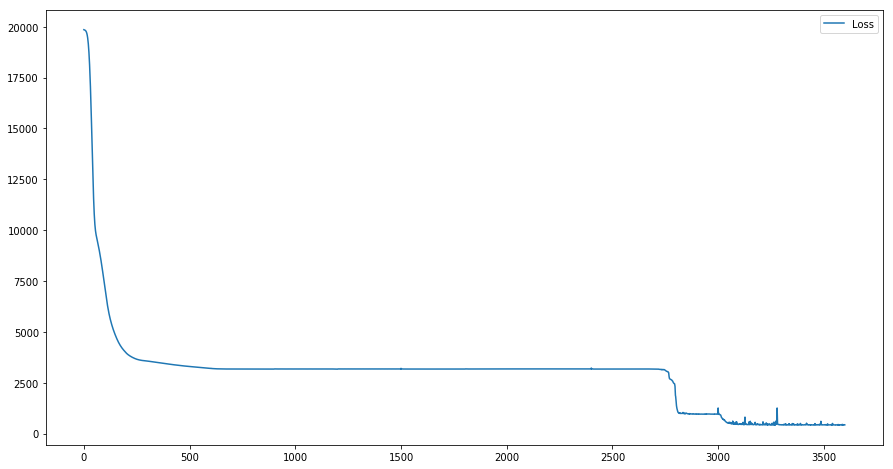

In [92]:
plt.plot(range(len(loss_list)), loss_list, label="Loss")
plt.legend()

train R^2: 95.62 %


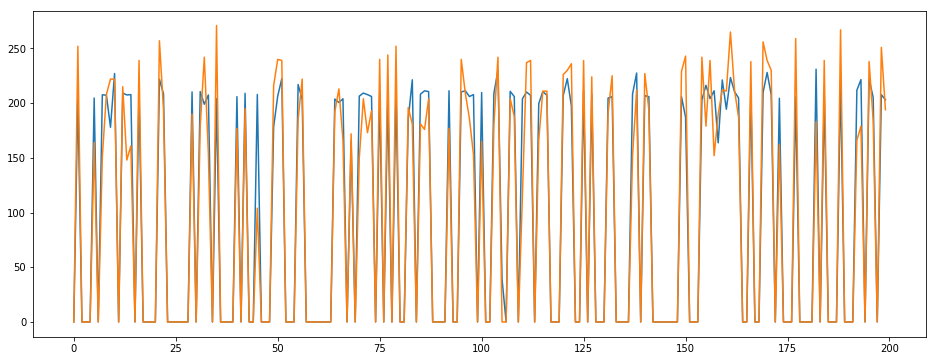

In [93]:
r2_train, prob_predicted_list_train, labels_list_train = evaluate_regression_model(train_loader, net)
print 'train R^2: %.2f %%'%(r2_train*100)
N1 = 500
N2 = 700
plt.figure(figsize=(16,6))
plt.plot(range(len(prob_predicted_list_train[N1:N2])), prob_predicted_list_train[N1:N2]);
plt.plot(range(len(labels_list_train[N1:N2])), labels_list_train[N1:N2]);

test R^2: 94.71 %


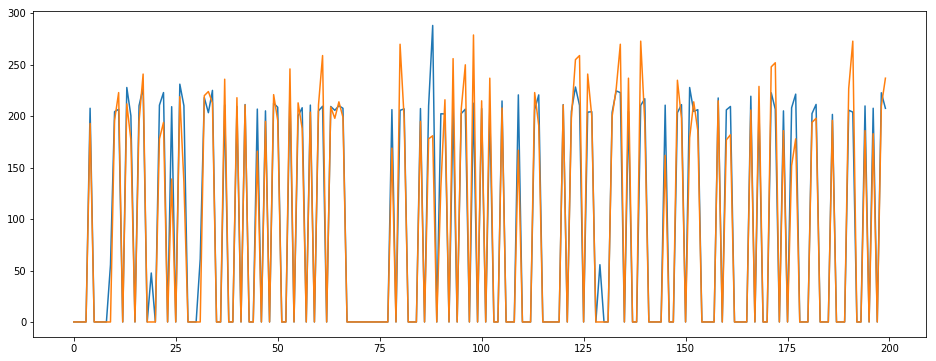

In [94]:
r2_test, prob_predicted_list_test, labels_list_test = evaluate_regression_model(test_loader, net)
print 'test R^2: %.2f %%'%(r2_test*100)
N1 = 500
N2 = 700
plt.figure(figsize=(16,6))
plt.plot(range(len(prob_predicted_list_test[N1:N2])), prob_predicted_list_test[N1:N2]);
plt.plot(range(len(labels_list_test[N1:N2])), labels_list_test[N1:N2]);